## This notebook calibrates the Cpx-Liq machine learning barometr used by Thermobar. 
- We follow Petrelli, where a different random state is used for pressure and temperature
- Note, this will likely need rerunning a lot, because it seems if sklearn changes version too much, the pickles wont load. 
- With each change in Sklearn, the answer will likely change. The change from v023.2 resulted in a change of up to ~0.8 kbar per Cpx. This is sadly unavoidable as far as we know, although if you have a suggestion please let us know!
- This was last run on April 24th 2022

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

In [5]:
import sklearn

print(sklearn.__version__)

1.3.0


In [6]:
out_train=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Train_Thermobar_Format')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Liq_train=out_train['Liqs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
Liq_train_noID_noT=Liq_train.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
Cpx_Liq_Combo_train=pd.concat([Liq_train_noID_noT, Cpx_train_noID_noT], axis=1)
x_train=Cpx_Liq_Combo_train.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_GPa']*10

In [7]:
## Test dataset
out_test=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Test_Thermobar_Format')
out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']
Liq_test=out_test['Liqs']
Cpx_test_noID_noT=Cpx_test.drop(['Sample_ID_Cpx'], axis=1)
Liq_test_noID_noT=Liq_test.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
Cpx_Liq_Combo_test=pd.concat([Liq_test_noID_noT, Cpx_test_noID_noT], axis=1)
x_test=Cpx_Liq_Combo_test.values
y_test_T=out_test_input['T_K']
y_test_P=out_test_input['P_GPa']*10

In [9]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Define the regressor, in our case the Extra Tree Regressor
regr_T = ExtraTreesRegressor(n_estimators=550, criterion='squared_error',
                             max_features=22, random_state=280) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=350, criterion='squared_error', 
                             max_features=22, random_state=80) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())

ExtraTreesRegressor(max_features=22, n_estimators=350, random_state=80)

In [10]:
x_test_scaled=scaler.transform(x_test)

## Predicting the test data for temp

'RMSE= 53.87672'

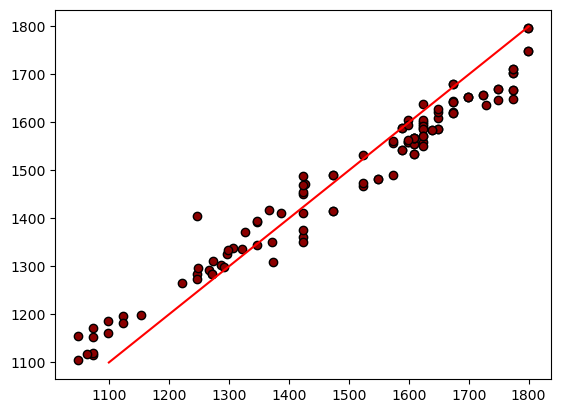

In [11]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)
Stats_T['R2']
Stats_T['RMSE']

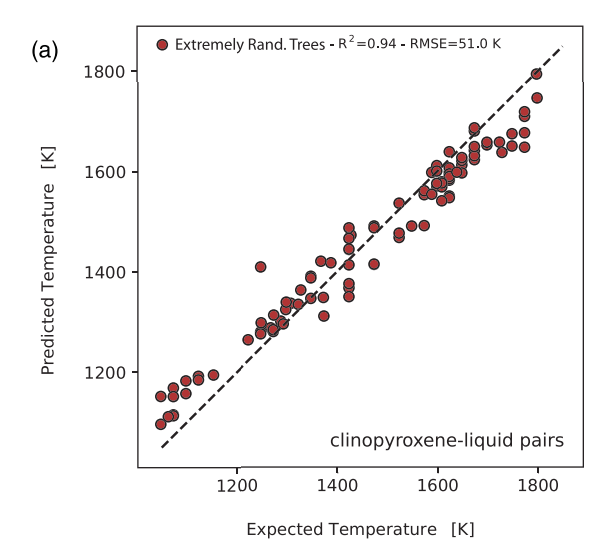

## Predicting the test data for Press

'RMSE= 2.90829'

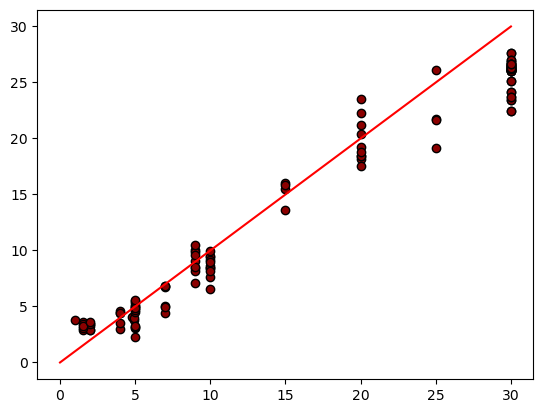

In [12]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
Stats_P['R2']
Stats_P['RMSE']

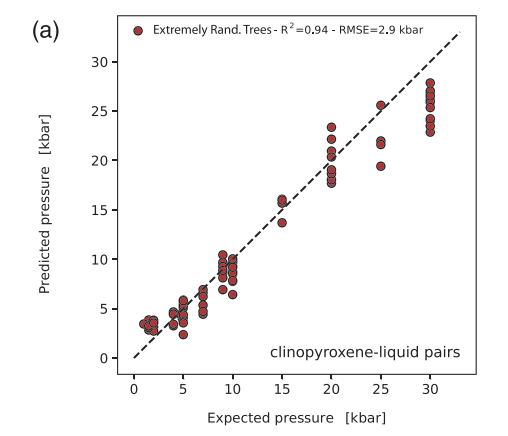

## Old way from Jan 22, In Oct 23, had a big enough change, got the following error when you tried to run thermobar.
- Had to retrain
- ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')] 



In [13]:


# from pickle import dump
# dump(scaler, open('scaler_Petrelli2020_Cpx_Liq_Jan22.pkl', 'wb'))


# import joblib
# joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)
# joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)

## New one made Oct 6th, 2023, saving as sklearn version for comparison

In [15]:


from pickle import dump
dump(scaler, open('scaler_Petrelli2020_Cpx_Liq_sklearn_1_3.pkl', 'wb'))

scaler_Petrelli2020_Cpx_Liq_sklearn_1_3.pkl

import joblib
joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Liq_sklearn_1_3.pkl',compress=3)
joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Liq_sklearn_1_3.pkl',compress=3)

['ETR_Temp_Petrelli2020_Cpx_Liq_sklearn_1_3.pkl']